# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [x] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames
- [ ] Cutoffs
    - https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c
    - Find Lower/Upper Bounds which maximises competition metric
- [ ] May be try several CVs
- [ ] May be play with uplift to lessen features input
    

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

import joblib
import os
import shutil
import itertools

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
mining_columns: list = [i for i in dataset_df.columns if i not in ["Id","Class"]]

def compute_basic_stats(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    
    out: dict = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

# Train
basic_stats_1 = compute_basic_stats(columns=mining_columns, df=dataset_df)

basic_stats_1.to_pickle('/kaggle/working/basic_stats_1.pickle')

# Inference
# basic_stats_1 = pd.read_pickle('/kaggle/working/basic_stats_1.pickle')

  0%|          | 0/56 [00:00<?, ?it/s]

In [7]:
basic_stats_1

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [8]:
WoE_Columns = ['DU', 'BC', 'AF', 'EH', 'AM', 'FD', 'DI', 'FR', 'AB', 'CF', 'BZ', 'FE', 'AX', 'BR',
               'GB', 'AY', 'FC', 'FS', 'CC', 'GH', 'DV', 'DY', 'EE', 'GE', 'AH', 'DN', 'EP', 'EU',
               'EG', 'FI', 'DH', 'GF', 'GI', 'DE', 'DA', 'CW', 'CU', 'AZ', 'CL', 'CH', 'BD', 'BN',
               'DL', 'CS', 'FL', 'GL', 'CB', 'DF', 'BP', 'EB', 'AR', 'CD', 'EL', 'CR', 'BQ']

In [9]:
def preprocess_train(train: pd.DataFrame, numeric_features: list, save_path: str) -> None:
    woes = dict()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train[i], y=train['Class'])
        woes[i] = tmp_woe
    
    # Save WoE
    _ = joblib.dump(value=woes, filename=save_path)
    print('Saved features: ', save_path)
    
    return None

def preprocess_inference(train: pd.DataFrame, test: pd.DataFrame, 
                         numeric_features: list,
                         stats: pd.DataFrame, save_path: str) -> (pd.DataFrame, pd.DataFrame, list):
    info = dict()
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    woes = joblib.load(save_path)
    
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        train_out[i + '_WoE'] = woes[i].transform(X=train_out[i])
        test_out[i + '_WoE'] = woes[i].transform(X=test_out[i])
        out_features.append(i + '_WoE')
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features


# Only for Train
_ = preprocess_train(train=dataset_df, numeric_features=WoE_Columns, save_path='/kaggle/working/WoE.pickle')

# For Train & Inference
train_out,test_out,features = preprocess_inference(train=dataset_df, 
                                                   test=dataset_test_df,
                                                   stats=basic_stats_1, 
                                                   numeric_features=WoE_Columns,
                                                   save_path='/kaggle/working/WoE.pickle')

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Saved features:  /kaggle/working/WoE.pickle


WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [10]:
class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

class TFDF_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = tfdf.keras.RandomForestModel, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(), model_compile_kwargs = dict()):

        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X['Class'])):
                print('##### Fold',i+1)

                # Fetch values corresponding to the index 
                train_df = X.iloc[train_index]
                valid_df = X.iloc[valid_index]
                valid_ids = valid_df.index.values
                train_ids = train_df.index.values

                # Select only feature columns for training.
                train_df = train_df[self.features+[self.label]]
                valid_df = valid_df[self.features+[self.label]]

                # We need to convert the datatset from Pandas format (pd.DataFrame)
                train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=self.label)
                valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=self.label)

                # Define & Train the model and metrics
                model = self.model_obj(**model_kwargs)
                model.compile(**model_compile_kwargs) 
                model.fit(x=train_tf, class_weight=class_weight)

                # Store the model
                self.models[i] = model

                # Predict Values
                self.X_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
                self.valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()

                # Evaluate and store the metrics in respective dicts
                evaluation = model.evaluate(x=train_tf,return_dict=True)
                train_metric = evaluation["balanced_log_loss"]

                evaluation = model.evaluate(x=valid_tf,return_dict=True)
                val_metric = evaluation["balanced_log_loss"]

                # Plot Results
                plot_train_logs(model)

                balanced_logloss_train[i] = train_metric
                balanced_logloss_val[i] = val_metric

                print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")

        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(self.metrics['train']).mean():.4f} std: {pd.Series(self.metrics['train']).std():.4f}")
        print(f"\nValidation mean: {pd.Series(self.metrics['val']).mean():.4f} std: {pd.Series(self.metrics['val']).std():.4f}")
        
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X[self.features]) # Technial, to conert frame to tensor for makind a predictions using tensor framework
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict(x=X_tf).flatten() 
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            model.save(filepath=f'{save_path}/models/{fold}')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = tf.keras.models.load_model(f'{save_path}/models/{i}',
                                              custom_objects={"BalancedLogLoss": BalancedLogLoss})
            
        return self

```python
# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# load
CV_Ensemble_1_load = TFDF_CV_Ensemble()

CV_Ensemble_1_load = CV_Ensemble_1_load.load(save_path='/kaggle/working/RF/1')


# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1_load.X_summary
valid_summary_rf_1 = CV_Ensemble_1_load.valid_summary
test_summary_rf_1 = CV_Ensemble_1_load.predict(X=test_out)
model_rf_1 = CV_Ensemble_1_load.models
metrics_rf_1 = CV_Ensemble_1_load.metrics
```

```python
# Let's try to find Cutoffs organically
train_summary_rf_1_mean = train_summary_rf_1.mean(axis=1)
train_summary_rf_1_mean.name = 'Pred'

tmp = pd.concat([train_summary_rf_1_mean, train_out['Class']], axis=1).sort_index(ascending=True)

tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
tmp['count_cumsum'] = tmp['count'].cumsum()
tmp['sum_cumsum'] = tmp['sum'].cumsum()

tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

tmp['perc_sum'] = [*range(1,101)]

tmp
```

# RandomForestModel

##### Fold 1
Use /tmp/tmpbyyly1hi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.411605. Found 514 examples.
Training model...
Model trained in 0:00:00.842111
Compiling model...


[INFO 23-07-29 21:20:56.7390 UTC kernel.cc:1242] Loading model from path /tmp/tmpbyyly1hi/model/ with prefix 65336b72b71a440c
[INFO 23-07-29 21:20:56.8809 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33286 node(s), and 113 input feature(s).
[INFO 23-07-29 21:20:56.8812 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:20:56.8814 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3276


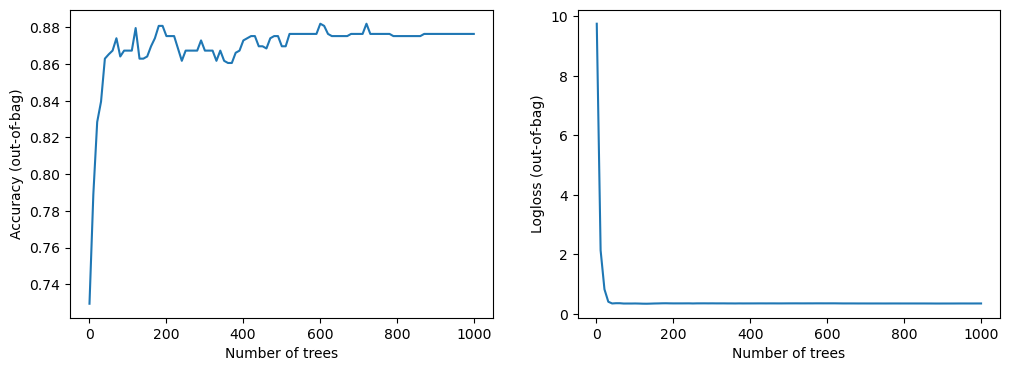


Train: 0.1731 Validation: 0.3276
##### Fold 2
Use /tmp/tmpscxzd1dd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.103542. Found 514 examples.
Training model...
Model trained in 0:00:00.821609
Compiling model...


[INFO 23-07-29 21:21:06.3798 UTC kernel.cc:1242] Loading model from path /tmp/tmpscxzd1dd/model/ with prefix ccab0ffa9aa34419
[INFO 23-07-29 21:21:06.5253 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33396 node(s), and 113 input feature(s).
[INFO 23-07-29 21:21:06.5253 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 390ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9515 - balanced_log_loss: 0.2998


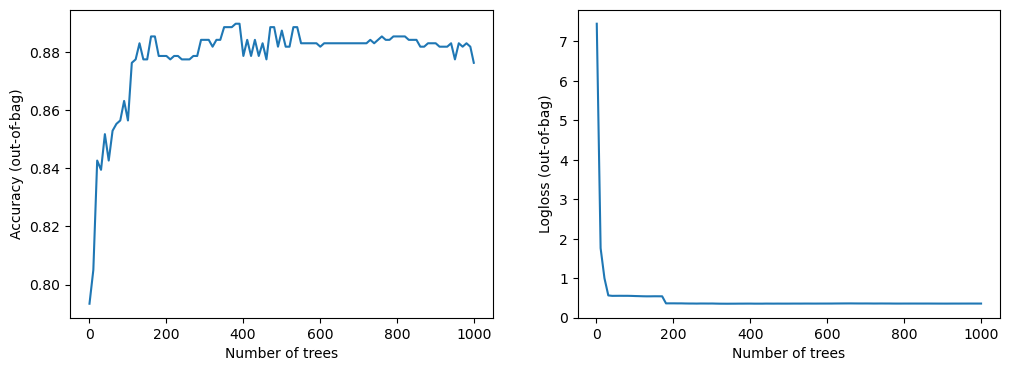


Train: 0.5067 Validation: 0.2998
##### Fold 3
Use /tmp/tmpl37z96fx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.134323. Found 514 examples.
Training model...
Model trained in 0:00:00.789297
Compiling model...


[INFO 23-07-29 21:21:13.5507 UTC kernel.cc:1242] Loading model from path /tmp/tmpl37z96fx/model/ with prefix 54fa9cfff1324453
[INFO 23-07-29 21:21:13.6891 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33376 node(s), and 113 input feature(s).
[INFO 23-07-29 21:21:13.6892 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:21:13.6893 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 387ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3269


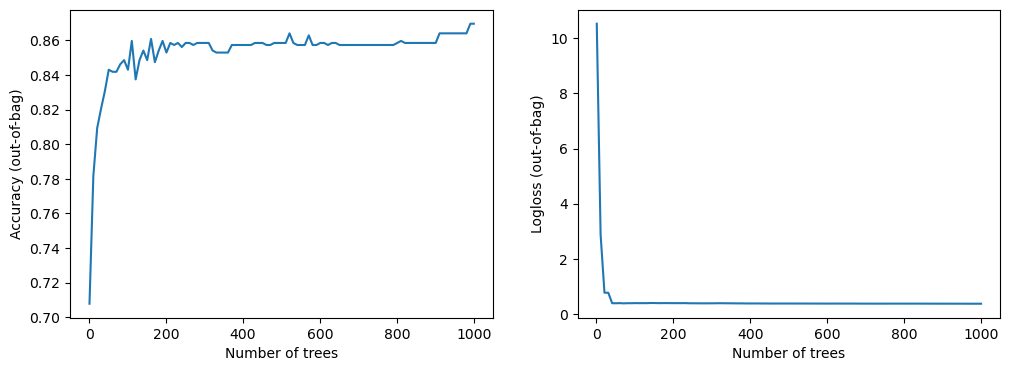


Train: 0.4829 Validation: 0.3269
##### Fold 4
Use /tmp/tmpexhtw2kc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.100657. Found 514 examples.
Training model...
Model trained in 0:00:00.794577
Compiling model...


[INFO 23-07-29 21:21:20.2670 UTC kernel.cc:1242] Loading model from path /tmp/tmpexhtw2kc/model/ with prefix 08862de9c48c4d65
[INFO 23-07-29 21:21:20.4058 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33208 node(s), and 113 input feature(s).
[INFO 23-07-29 21:21:20.4059 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 387ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3500


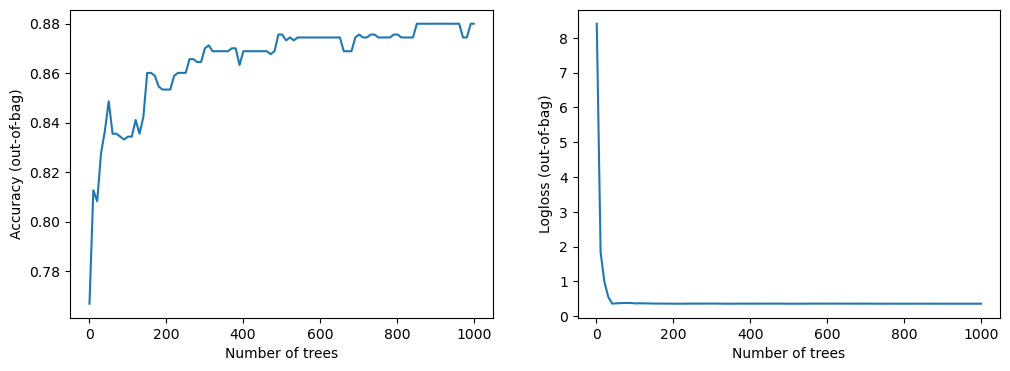


Train: 0.5023 Validation: 0.3500
##### Fold 5
Use /tmp/tmpiwuu6kw4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.116280. Found 514 examples.
Training model...
Model trained in 0:00:00.794464
Compiling model...


[INFO 23-07-29 21:21:27.4999 UTC kernel.cc:1242] Loading model from path /tmp/tmpiwuu6kw4/model/ with prefix d63922dcc8474441
[INFO 23-07-29 21:21:27.6394 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33428 node(s), and 113 input feature(s).
[INFO 23-07-29 21:21:27.6394 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:21:27.6395 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3811


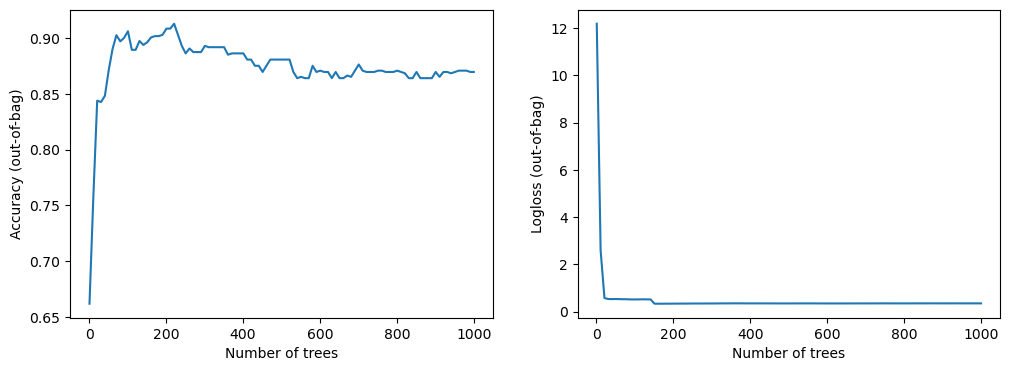


Train: 0.5224 Validation: 0.3811
##### Fold 6
Use /tmp/tmpef7jau2q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.103893. Found 515 examples.
Training model...
Model trained in 0:00:00.805712
Compiling model...


[INFO 23-07-29 21:21:34.7306 UTC kernel.cc:1242] Loading model from path /tmp/tmpef7jau2q/model/ with prefix b865db6a13cf42e1
[INFO 23-07-29 21:21:34.8720 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33260 node(s), and 114 input feature(s).
[INFO 23-07-29 21:21:34.8721 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 395ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9020 - balanced_log_loss: 0.4208


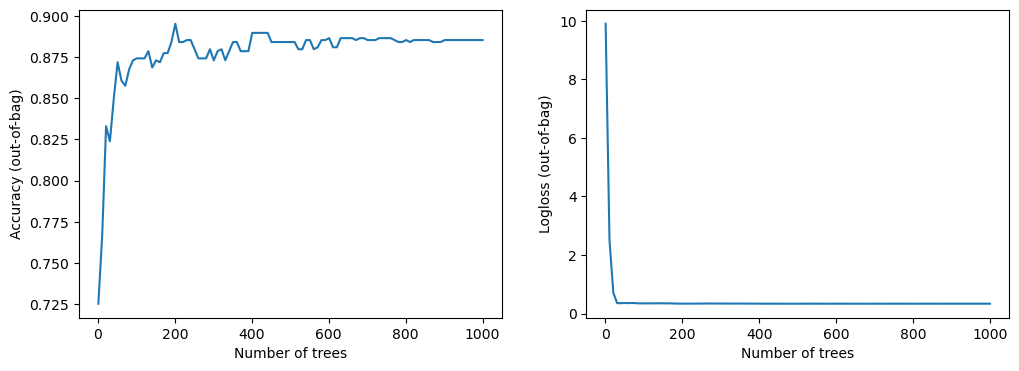


Train: 0.5493 Validation: 0.4208

Train mean: 0.4561 std: 0.1404

Validation mean: 0.3510 std: 0.0437
1/1 [==============================] - 0s 244ms/step


In [11]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1.X_summary
valid_summary_rf_1 = CV_Ensemble_1.valid_summary
test_summary_rf_1 = CV_Ensemble_1.predict(X=test_out)
model_rf_1 = CV_Ensemble_1.models
metrics_rf_1 = CV_Ensemble_1.metrics

##### Fold 1
Use /tmp/tmp52xptv43 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.233300. Found 555 examples.
Training model...
Model trained in 0:00:00.273439
Compiling model...


[INFO 23-07-29 21:22:18.4455 UTC kernel.cc:1242] Loading model from path /tmp/tmp52xptv43/model/ with prefix 49b98deacf2f4dbf
[INFO 23-07-29 21:22:18.4897 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10268 node(s), and 112 input feature(s).
[INFO 23-07-29 21:22:18.4898 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:22:18.4898 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 400ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3026


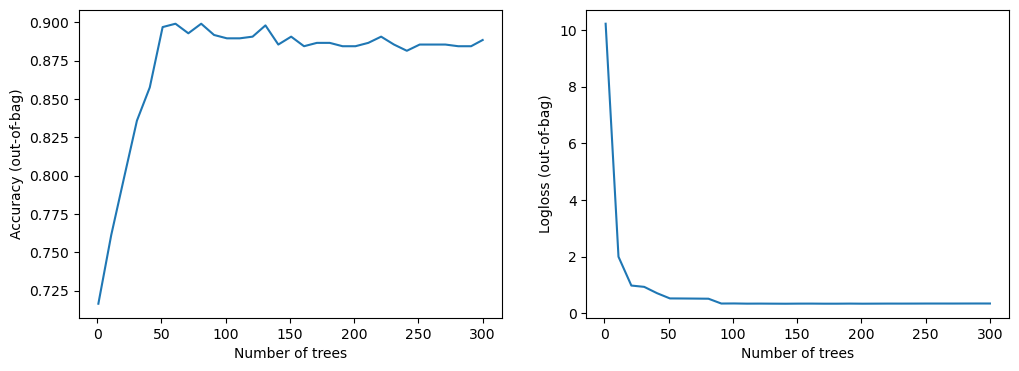


Train: 0.1776 Validation: 0.3026
##### Fold 2
Use /tmp/tmpujdb7y84 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.171228. Found 555 examples.
Training model...
Model trained in 0:00:00.274282
Compiling model...


[INFO 23-07-29 21:22:24.6186 UTC kernel.cc:1242] Loading model from path /tmp/tmpujdb7y84/model/ with prefix d3ebfb21b0cb48d6
[INFO 23-07-29 21:22:24.6622 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10250 node(s), and 110 input feature(s).
[INFO 23-07-29 21:22:24.6623 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3518


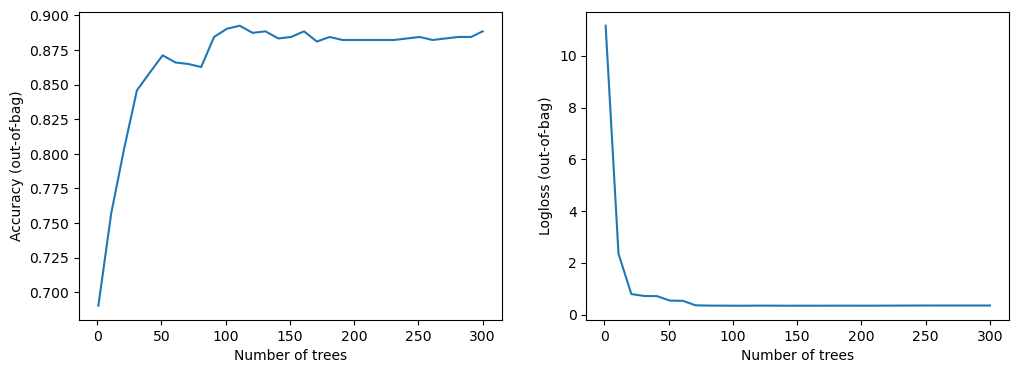


Train: 0.4775 Validation: 0.3518
##### Fold 3
Use /tmp/tmpn4vkunf4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.160808. Found 555 examples.
Training model...
Model trained in 0:00:00.272401
Compiling model...


[INFO 23-07-29 21:22:30.8035 UTC kernel.cc:1242] Loading model from path /tmp/tmpn4vkunf4/model/ with prefix 23b93144bf054977
[INFO 23-07-29 21:22:30.8466 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10302 node(s), and 113 input feature(s).
[INFO 23-07-29 21:22:30.8466 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:22:30.8467 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 374ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2532


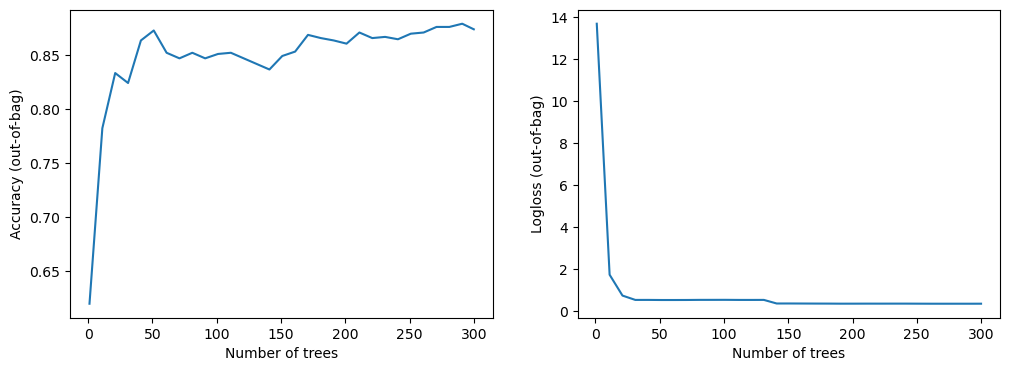


Train: 0.5394 Validation: 0.2532
##### Fold 4
Use /tmp/tmpfrdr4am2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.177159. Found 555 examples.
Training model...
Model trained in 0:00:00.274591
Compiling model...


[INFO 23-07-29 21:22:36.9074 UTC kernel.cc:1242] Loading model from path /tmp/tmpfrdr4am2/model/ with prefix 60a2151c3d804195
[INFO 23-07-29 21:22:36.9505 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10350 node(s), and 112 input feature(s).
[INFO 23-07-29 21:22:36.9506 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 370ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3232


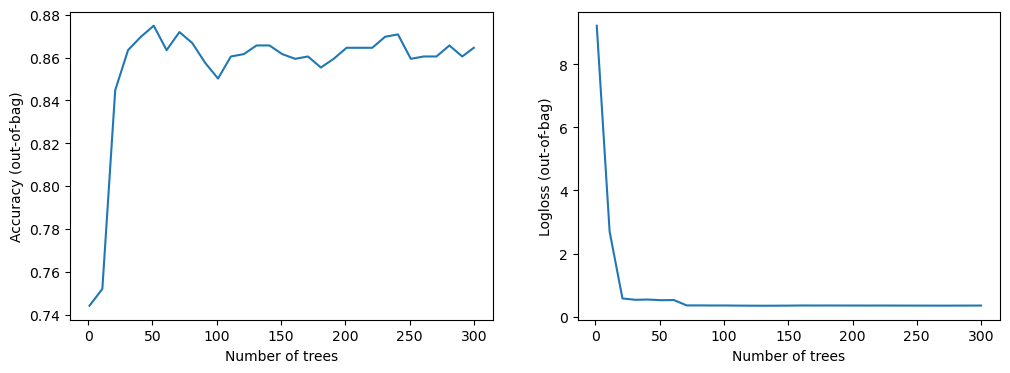


Train: 0.4308 Validation: 0.3232
##### Fold 5
Use /tmp/tmpyk9jwcdw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.211972. Found 555 examples.
Training model...
Model trained in 0:00:00.347733
Compiling model...


[INFO 23-07-29 21:22:44.2001 UTC kernel.cc:1242] Loading model from path /tmp/tmpyk9jwcdw/model/ with prefix 2ff25f449aad4614
[INFO 23-07-29 21:22:44.2493 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10290 node(s), and 112 input feature(s).
[INFO 23-07-29 21:22:44.2494 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:22:44.2494 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 369ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3334


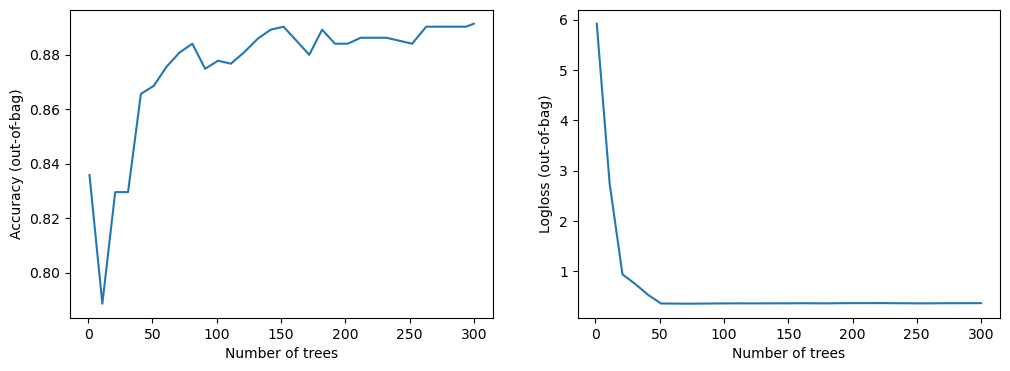


Train: 0.5062 Validation: 0.3334
##### Fold 6
Use /tmp/tmpvcjtu209 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.220934. Found 555 examples.
Training model...
Model trained in 0:00:00.271954
Compiling model...


[INFO 23-07-29 21:22:50.8330 UTC kernel.cc:1242] Loading model from path /tmp/tmpvcjtu209/model/ with prefix 6d322ad1c64d4f26
[INFO 23-07-29 21:22:50.8786 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10464 node(s), and 113 input feature(s).
[INFO 23-07-29 21:22:50.8787 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4007


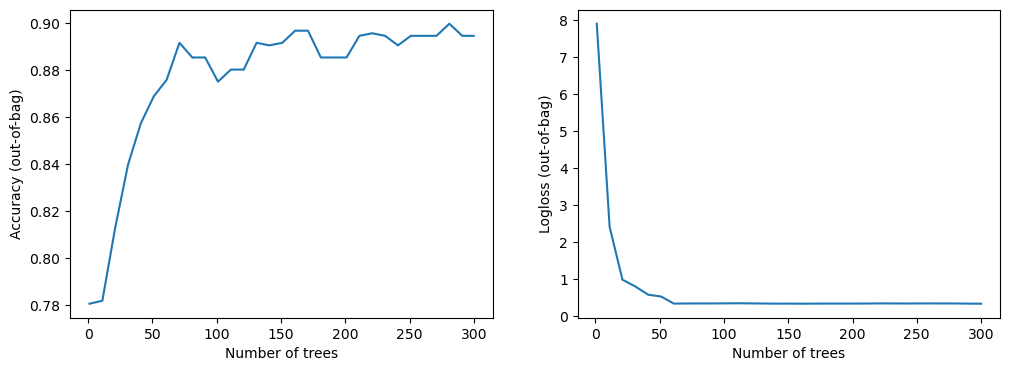


Train: 0.5031 Validation: 0.4007
##### Fold 7
Use /tmp/tmpj79loyjq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.125313. Found 555 examples.
Training model...
Model trained in 0:00:00.265522
Compiling model...


[INFO 23-07-29 21:22:57.0098 UTC kernel.cc:1242] Loading model from path /tmp/tmpj79loyjq/model/ with prefix 39374241546c4993
[INFO 23-07-29 21:22:57.0530 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10096 node(s), and 113 input feature(s).
[INFO 23-07-29 21:22:57.0530 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:22:57.0531 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 368ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3264


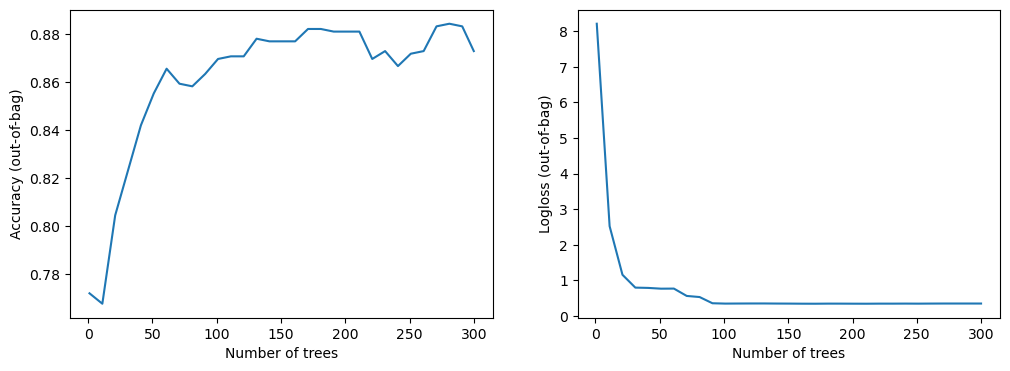


Train: 0.5776 Validation: 0.3264
##### Fold 8
Use /tmp/tmpnvsbr6c8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.205200. Found 556 examples.
Training model...
Model trained in 0:00:00.288974
Compiling model...


[INFO 23-07-29 21:23:03.1373 UTC kernel.cc:1242] Loading model from path /tmp/tmpnvsbr6c8/model/ with prefix a2607f45f9a14e6f
[INFO 23-07-29 21:23:03.1852 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10276 node(s), and 113 input feature(s).
[INFO 23-07-29 21:23:03.1853 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 387ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.3201


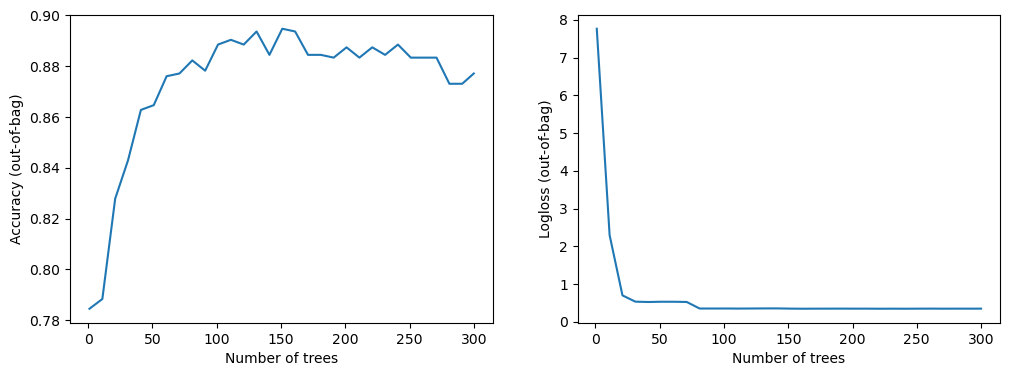


Train: 0.5045 Validation: 0.3201
##### Fold 9
Use /tmp/tmpu10sc66b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.175043. Found 556 examples.
Training model...
Model trained in 0:00:00.278417
Compiling model...


[INFO 23-07-29 21:23:09.3206 UTC kernel.cc:1242] Loading model from path /tmp/tmpu10sc66b/model/ with prefix 867b4b29d6a24e65
[INFO 23-07-29 21:23:09.3653 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10168 node(s), and 112 input feature(s).
[INFO 23-07-29 21:23:09.3653 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:23:09.3653 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 375ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4664


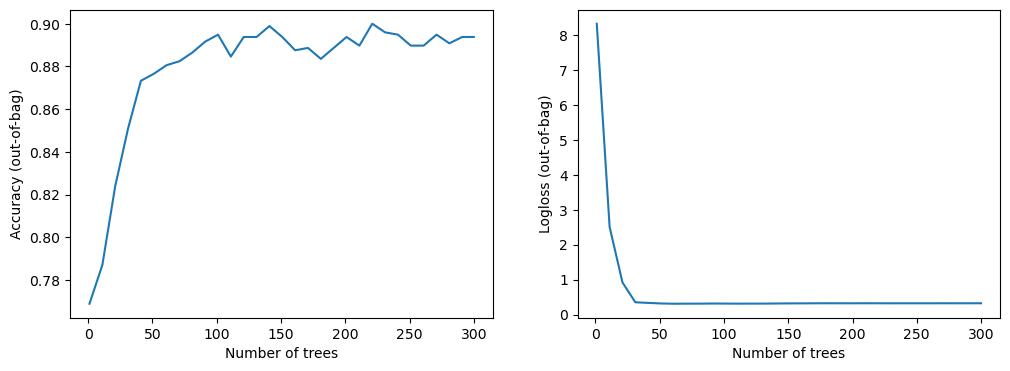


Train: 0.4883 Validation: 0.4664
##### Fold 10
Use /tmp/tmplv23yk92 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.287231. Found 556 examples.
Training model...
Model trained in 0:00:00.334070
Compiling model...


[INFO 23-07-29 21:23:15.6854 UTC kernel.cc:1242] Loading model from path /tmp/tmplv23yk92/model/ with prefix ece02396c75a438c
[INFO 23-07-29 21:23:15.7285 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10406 node(s), and 111 input feature(s).
[INFO 23-07-29 21:23:15.7286 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.3531


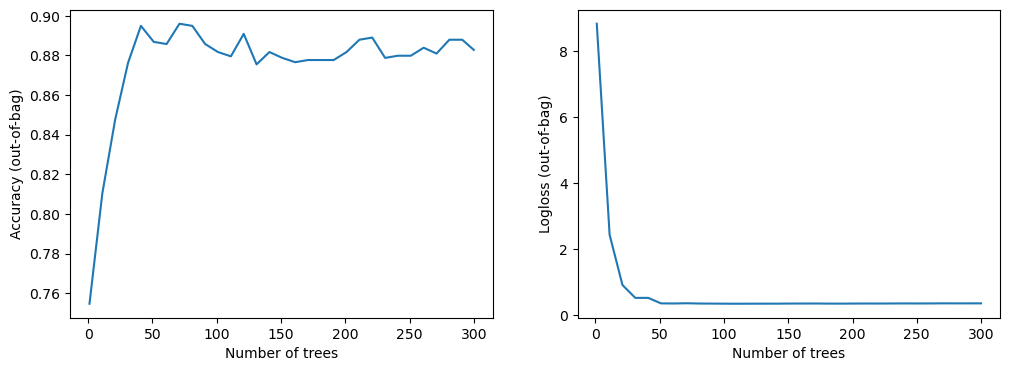


Train: 0.6396 Validation: 0.3531

Train mean: 0.4845 std: 0.1221

Validation mean: 0.3431 std: 0.0574
1/1 [==============================] - 0s 244ms/step


In [12]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_2 = CV_Ensemble_2.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_2.save(save_path='/kaggle/working/RF/2')

# Collect attributes and predictions

train_summary_rf_2 = CV_Ensemble_2.X_summary
valid_summary_rf_2 = CV_Ensemble_2.valid_summary
test_summary_rf_2 = CV_Ensemble_2.predict(X=test_out)
model_rf_2 = CV_Ensemble_2.models
metrics_rf_2 = CV_Ensemble_2.metrics


##### Fold 1
Use /tmp/tmpya4w2b7n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.368686. Found 555 examples.
Training model...
Model trained in 0:00:00.200775
Compiling model...


[INFO 23-07-29 21:24:24.8277 UTC kernel.cc:1242] Loading model from path /tmp/tmpya4w2b7n/model/ with prefix 5b66dbacd2a64878
[INFO 23-07-29 21:24:24.8757 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11260 node(s), and 59 input feature(s).
[INFO 23-07-29 21:24:24.8758 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:24:24.8758 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 305ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3091


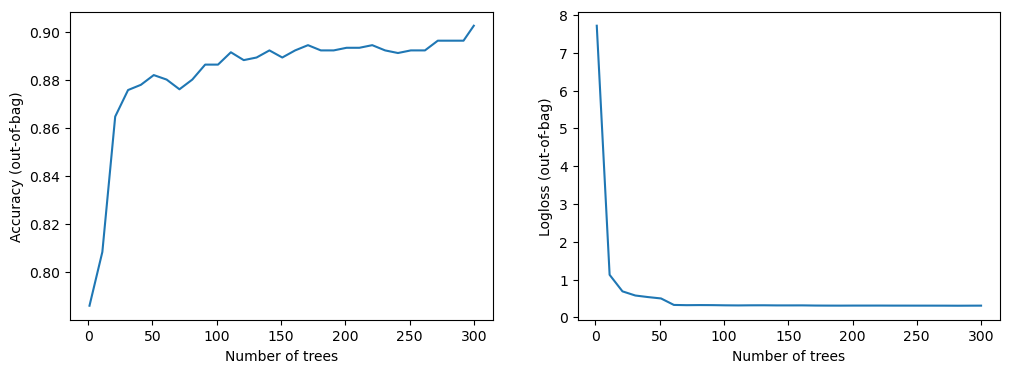


Train: 0.1883 Validation: 0.3091
##### Fold 2
Use /tmp/tmpbd07va5p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.329833. Found 555 examples.
Training model...
Model trained in 0:00:00.224696
Compiling model...


[INFO 23-07-29 21:24:29.1463 UTC kernel.cc:1242] Loading model from path /tmp/tmpbd07va5p/model/ with prefix 969b7fafbfae4e68
[INFO 23-07-29 21:24:29.1964 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:29.1965 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 306ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3418


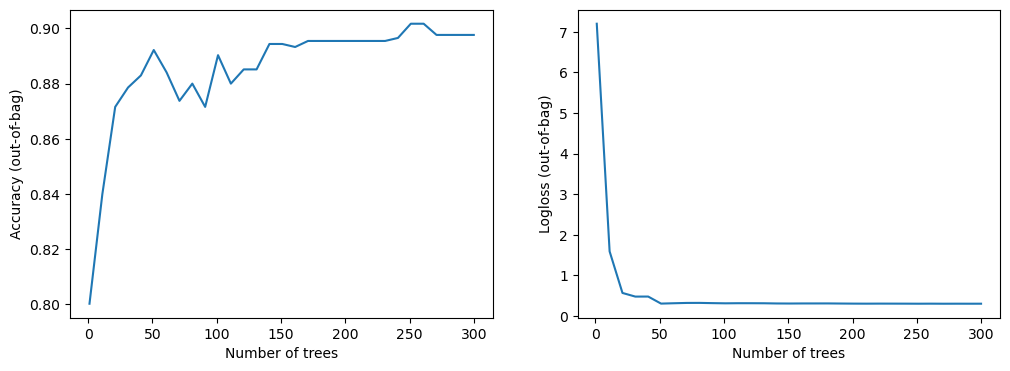


Train: 0.4968 Validation: 0.3418
##### Fold 3
Use /tmp/tmpg2fxs8tv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.417393. Found 555 examples.
Training model...
Model trained in 0:00:00.212492
Compiling model...


[INFO 23-07-29 21:24:33.5066 UTC kernel.cc:1242] Loading model from path /tmp/tmpg2fxs8tv/model/ with prefix 4251bedb01924270
[INFO 23-07-29 21:24:33.5573 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:33.5573 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 289ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2186


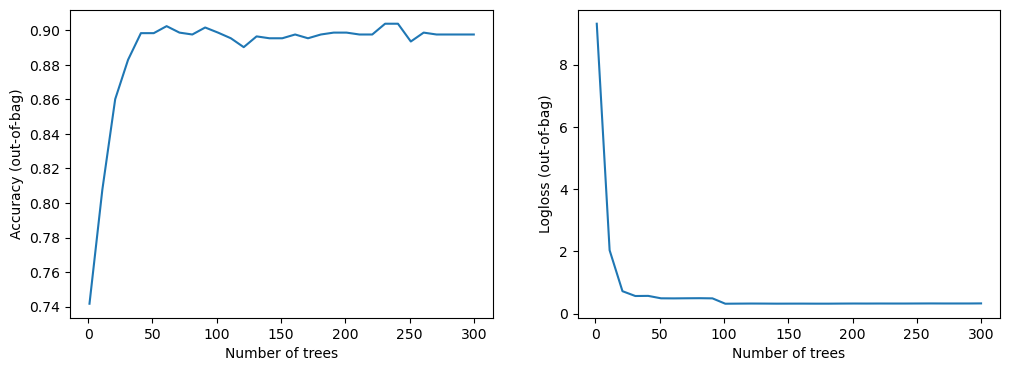


Train: 0.5382 Validation: 0.2186
##### Fold 4
Use /tmp/tmpjvvi8wn2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.340989. Found 555 examples.
Training model...
Model trained in 0:00:00.257007
Compiling model...


[INFO 23-07-29 21:24:37.8672 UTC kernel.cc:1242] Loading model from path /tmp/tmpjvvi8wn2/model/ with prefix 6f658324267c4aec
[INFO 23-07-29 21:24:37.9199 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11274 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:37.9199 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:24:37.9200 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 293ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2880


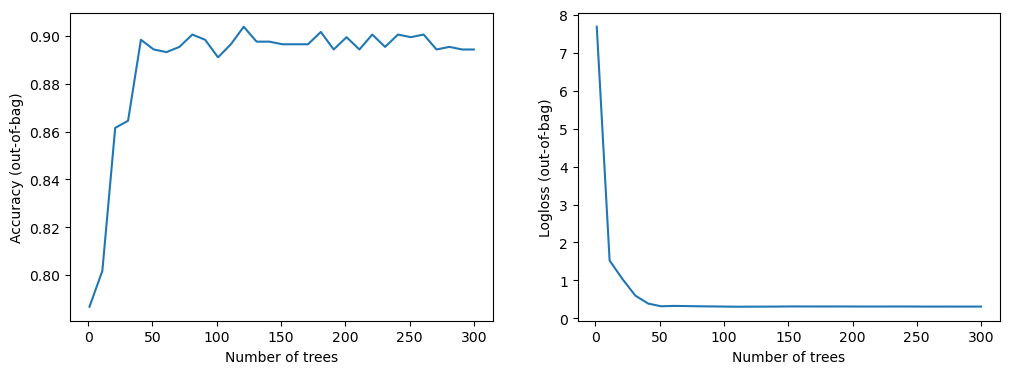


Train: 0.4091 Validation: 0.2880
##### Fold 5
Use /tmp/tmp3yiis9hg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.403857. Found 555 examples.
Training model...
Model trained in 0:00:00.214586
Compiling model...


[INFO 23-07-29 21:24:42.1730 UTC kernel.cc:1242] Loading model from path /tmp/tmp3yiis9hg/model/ with prefix 5fc3a672025849c2
[INFO 23-07-29 21:24:42.2225 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11210 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:42.2225 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 314ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2901


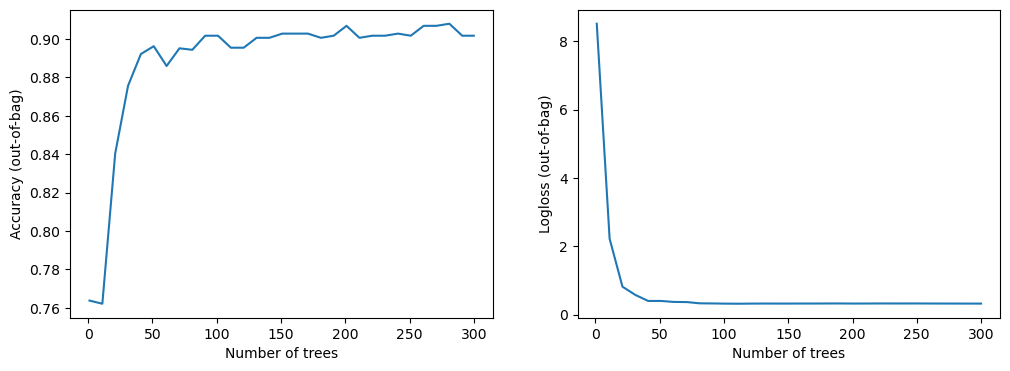


Train: 0.4847 Validation: 0.2901
##### Fold 6
Use /tmp/tmp53uzjvpk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.457313. Found 555 examples.
Training model...
Model trained in 0:00:00.203075
Compiling model...


[INFO 23-07-29 21:24:46.5019 UTC kernel.cc:1242] Loading model from path /tmp/tmp53uzjvpk/model/ with prefix 9721e9f9f6a4448b
[INFO 23-07-29 21:24:46.5495 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11268 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:46.5495 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 330ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3444


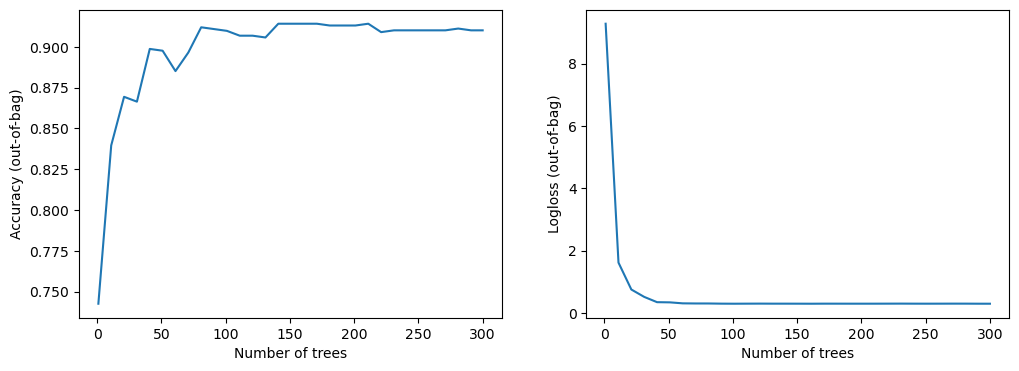


Train: 0.4697 Validation: 0.3444
##### Fold 7
Use /tmp/tmp8xuvu59n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.383819. Found 555 examples.
Training model...
Model trained in 0:00:00.207616
Compiling model...


[INFO 23-07-29 21:24:50.8891 UTC kernel.cc:1242] Loading model from path /tmp/tmp8xuvu59n/model/ with prefix da96c186aeac45d7
[INFO 23-07-29 21:24:50.9388 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11172 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:50.9389 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:24:50.9389 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 299ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2836


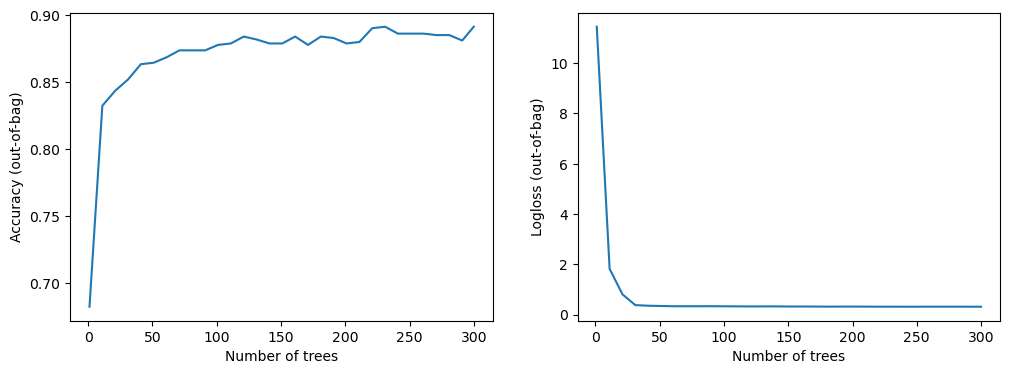


Train: 0.5343 Validation: 0.2836
##### Fold 8
Use /tmp/tmpfvimzq1d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.467963. Found 556 examples.
Training model...
Model trained in 0:00:00.202255
Compiling model...


[INFO 23-07-29 21:24:55.2526 UTC kernel.cc:1242] Loading model from path /tmp/tmpfvimzq1d/model/ with prefix c578f56f90f64869
[INFO 23-07-29 21:24:55.2989 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11026 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:55.2990 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2572


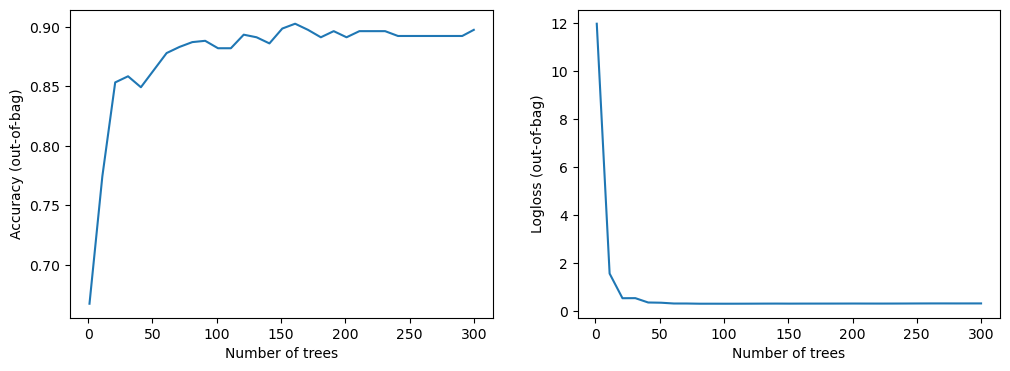


Train: 0.4778 Validation: 0.2572
##### Fold 9
Use /tmp/tmp44uggv4t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.383880. Found 556 examples.
Training model...
Model trained in 0:00:00.205048
Compiling model...


[INFO 23-07-29 21:24:59.4088 UTC kernel.cc:1242] Loading model from path /tmp/tmp44uggv4t/model/ with prefix 56cf1f4f989544dc
[INFO 23-07-29 21:24:59.4555 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11098 node(s), and 58 input feature(s).
[INFO 23-07-29 21:24:59.4556 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 332ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4250


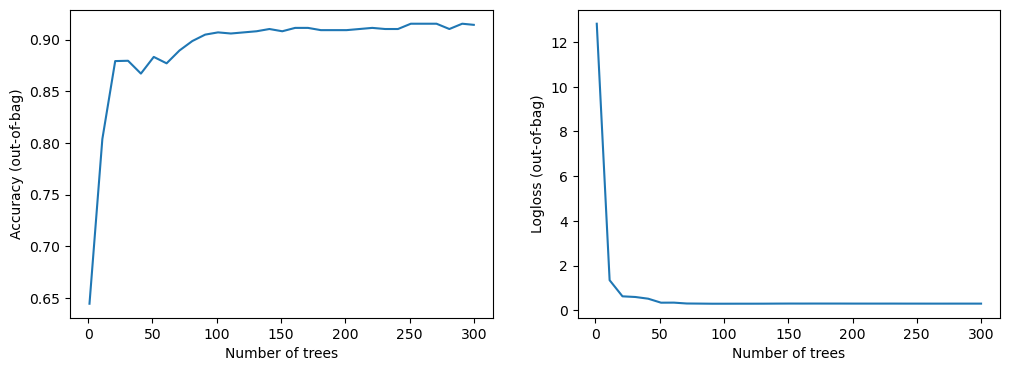


Train: 0.4395 Validation: 0.4250
##### Fold 10
Use /tmp/tmpam0cpt30 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.466932. Found 556 examples.
Training model...
Model trained in 0:00:00.221676
Compiling model...


[INFO 23-07-29 21:25:05.0606 UTC kernel.cc:1242] Loading model from path /tmp/tmpam0cpt30/model/ with prefix 59f018786c514c90
[INFO 23-07-29 21:25:05.1132 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11344 node(s), and 58 input feature(s).
[INFO 23-07-29 21:25:05.1133 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 21:25:05.1133 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 291ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3016


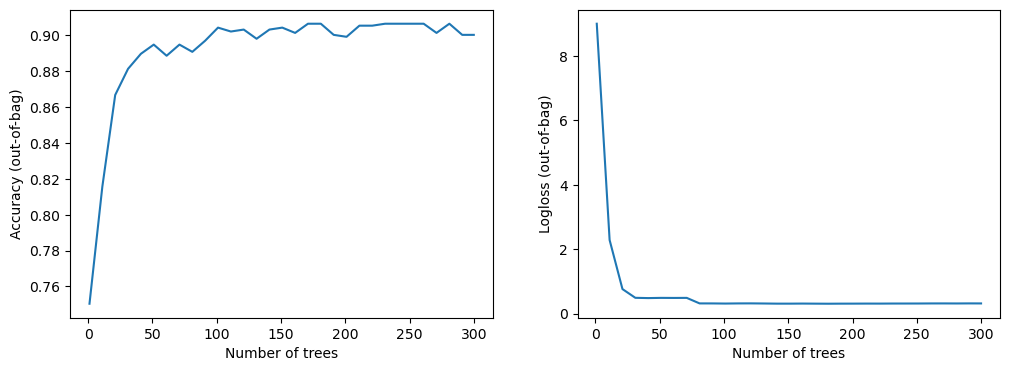


Train: 0.6154 Validation: 0.3016

Train mean: 0.4654 std: 0.1129

Validation mean: 0.3059 std: 0.0558
1/1 [==============================] - 0s 148ms/step


In [13]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_3 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_3 = CV_Ensemble_3.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_3.save(save_path='/kaggle/working/RF/3')

# Collect attributes and predictions

train_summary_rf_3 = CV_Ensemble_3.X_summary
valid_summary_rf_3 = CV_Ensemble_3.valid_summary
test_summary_rf_3 = CV_Ensemble_3.predict(X=test_out)
model_rf_3 = CV_Ensemble_3.models
metrics_rf_3 = CV_Ensemble_3.metrics

# GradientBoostedTreesModel

##### Fold 1
Use /tmp/tmppnx86ry6 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:25:44.1473 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:44.1473 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:44.1473 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.270266. Found 555 examples.
Training model...
Model trained in 0:00:00.756630
Compiling model...


[INFO 23-07-29 21:25:46.1777 UTC kernel.cc:1242] Loading model from path /tmp/tmppnx86ry6/model/ with prefix 9a14b14851554d28
[INFO 23-07-29 21:25:46.1834 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:25:46.1834 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2432


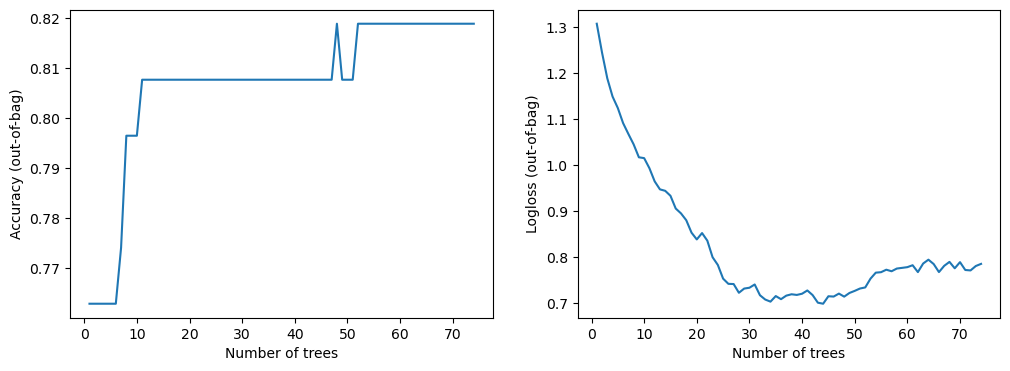


Train: 0.0893 Validation: 0.2432
##### Fold 2
Use /tmp/tmpcpxx4y5c as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:25:48.6122 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:48.6123 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:48.6123 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.259976. Found 555 examples.
Training model...
Model trained in 0:00:00.746919
Compiling model...


[INFO 23-07-29 21:25:50.6245 UTC kernel.cc:1242] Loading model from path /tmp/tmpcpxx4y5c/model/ with prefix dae1cf02b4f8417c
[INFO 23-07-29 21:25:50.6300 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2464


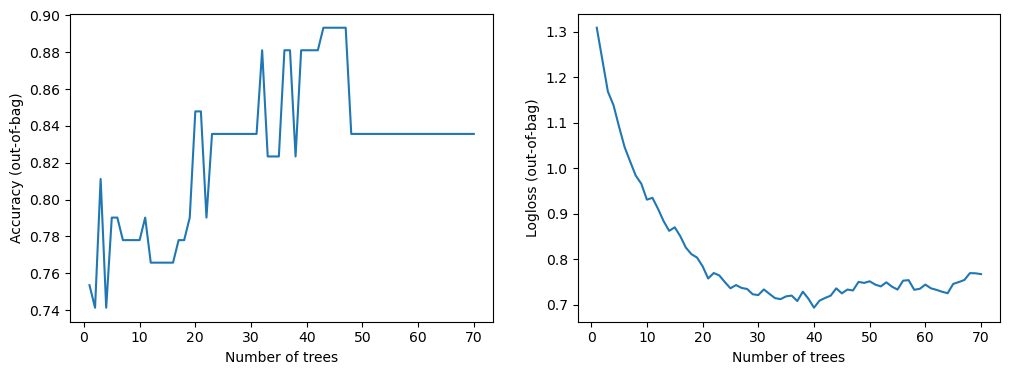


Train: 0.3326 Validation: 0.2464
##### Fold 3
Use /tmp/tmp3_9fxww6 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:25:54.3496 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:54.3496 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:54.3496 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.526798. Found 555 examples.
Training model...
Model trained in 0:00:00.925776
Compiling model...


[INFO 23-07-29 21:25:56.8027 UTC kernel.cc:1242] Loading model from path /tmp/tmp3_9fxww6/model/ with prefix d106de932cff4afc
[INFO 23-07-29 21:25:56.8106 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:25:56.8107 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 286ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1154


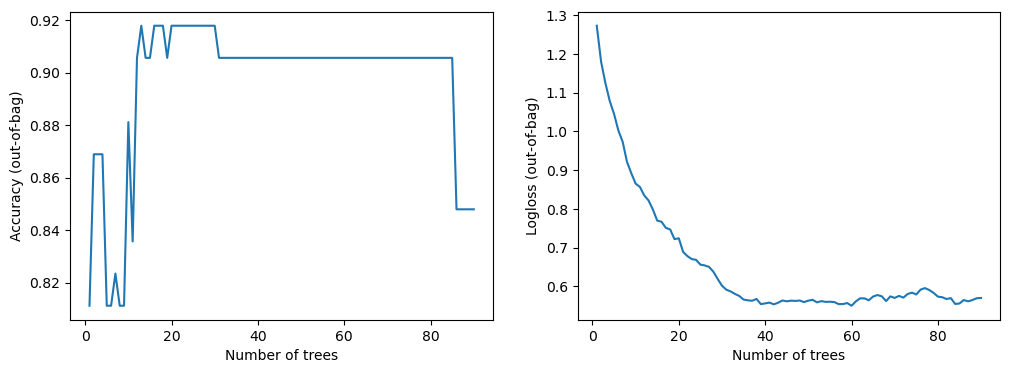


Train: 0.3043 Validation: 0.1154
##### Fold 4
Use /tmp/tmpwwp86qm9 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:25:59.3617 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:59.3618 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:25:59.3618 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.315537. Found 555 examples.
Training model...
Model trained in 0:00:00.653307
Compiling model...


[INFO 23-07-29 21:26:01.3356 UTC kernel.cc:1242] Loading model from path /tmp/tmpwwp86qm9/model/ with prefix dbd8209f9a744233
[INFO 23-07-29 21:26:01.3404 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 293ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2950


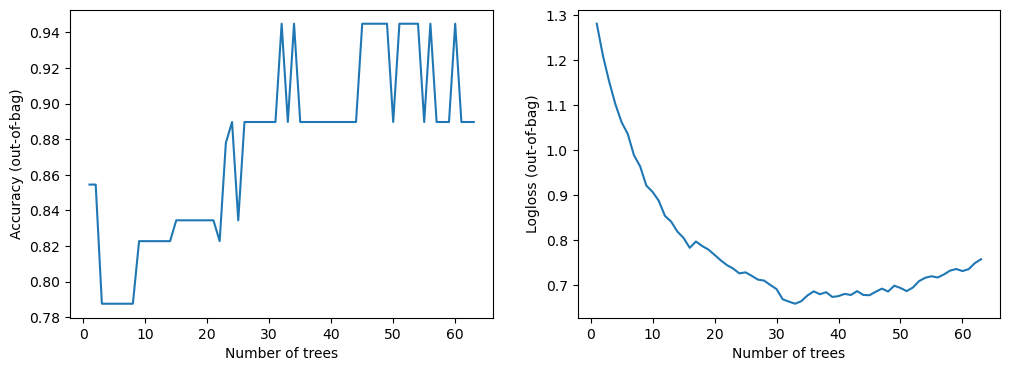


Train: 0.2279 Validation: 0.2950
##### Fold 5
Use /tmp/tmpd8t3bfc5 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:26:05.1277 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:05.1277 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:05.1277 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.362439. Found 555 examples.
Training model...
Model trained in 0:00:01.022000
Compiling model...


[INFO 23-07-29 21:26:07.5112 UTC kernel.cc:1242] Loading model from path /tmp/tmpd8t3bfc5/model/ with prefix eb9d116c222c4579
[INFO 23-07-29 21:26:07.5210 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:26:07.5212 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2456


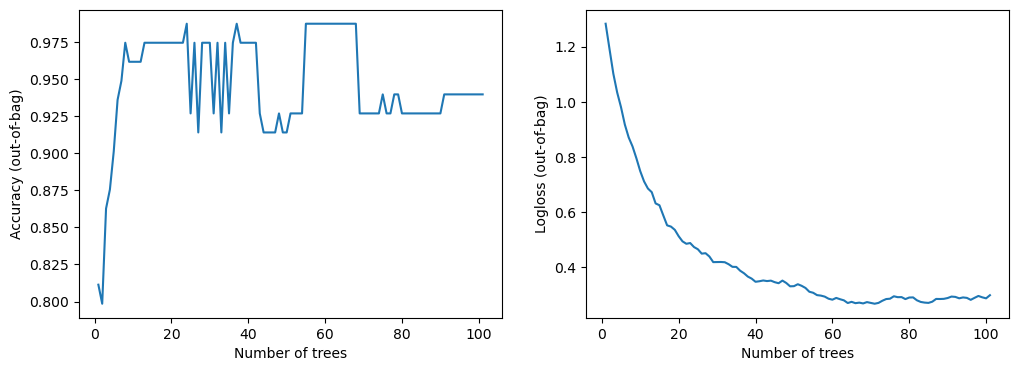


Train: 0.3301 Validation: 0.2456
##### Fold 6
Use /tmp/tmp7jg2hjyb as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:26:09.9943 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:09.9944 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:09.9944 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.281514. Found 555 examples.
Training model...
Model trained in 0:00:00.967968
Compiling model...


[INFO 23-07-29 21:26:12.2453 UTC kernel.cc:1242] Loading model from path /tmp/tmp7jg2hjyb/model/ with prefix 105b58fc4d1e4224
[INFO 23-07-29 21:26:12.2531 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 285ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3147


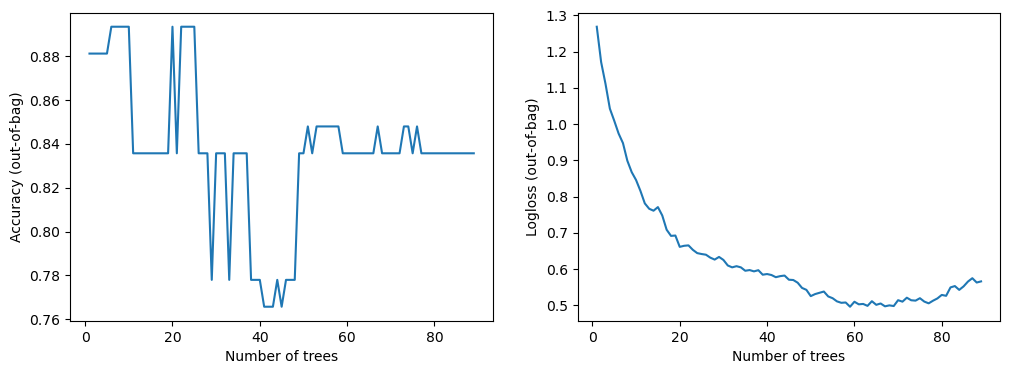


Train: 0.2965 Validation: 0.3147
##### Fold 7
Use /tmp/tmpzvm820os as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:26:14.7424 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:14.7424 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:14.7425 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.264440. Found 555 examples.
Training model...
Model trained in 0:00:01.077641
Compiling model...


[INFO 23-07-29 21:26:17.0835 UTC kernel.cc:1242] Loading model from path /tmp/tmpzvm820os/model/ with prefix 0b58d3ae99904aba
[INFO 23-07-29 21:26:17.0929 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 282ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3183


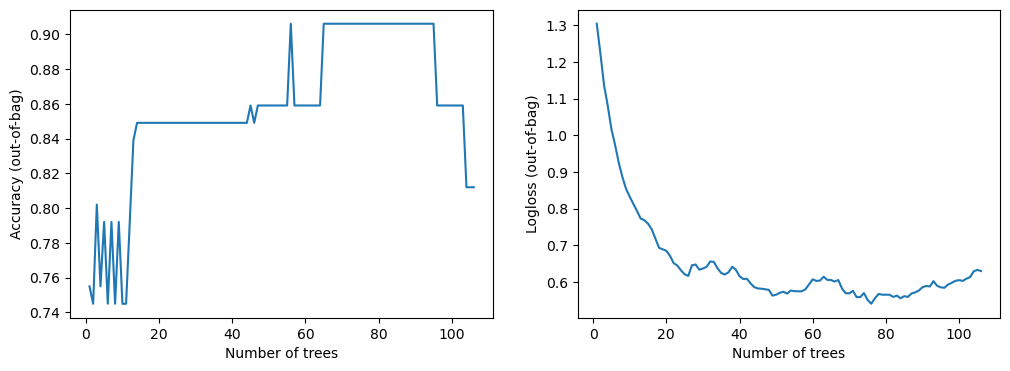


Train: 0.3593 Validation: 0.3183
##### Fold 8
Use /tmp/tmpn33dznta as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:26:20.3932 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:20.3933 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:20.3933 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.301856. Found 556 examples.
Training model...
Model trained in 0:00:01.280747
Compiling model...


[INFO 23-07-29 21:26:22.9740 UTC kernel.cc:1242] Loading model from path /tmp/tmpn33dznta/model/ with prefix c11a6035bee14178
[INFO 23-07-29 21:26:22.9851 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:26:22.9853 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1722


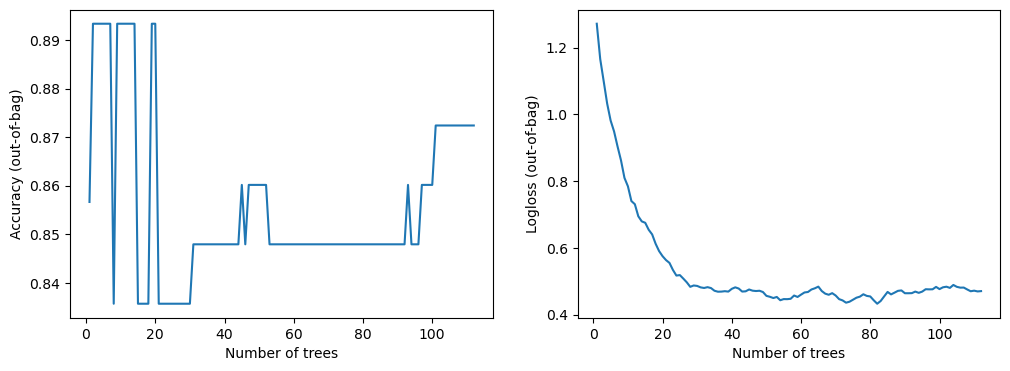


Train: 0.3549 Validation: 0.1722
##### Fold 9
Use /tmp/tmpxgxh6vau as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:26:25.4488 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:25.4489 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:25.4489 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.308216. Found 556 examples.
Training model...
Model trained in 0:00:02.095068
Compiling model...


[INFO 23-07-29 21:26:28.8406 UTC kernel.cc:1242] Loading model from path /tmp/tmpxgxh6vau/model/ with prefix 883298cc29134d41
[INFO 23-07-29 21:26:28.8614 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.9113


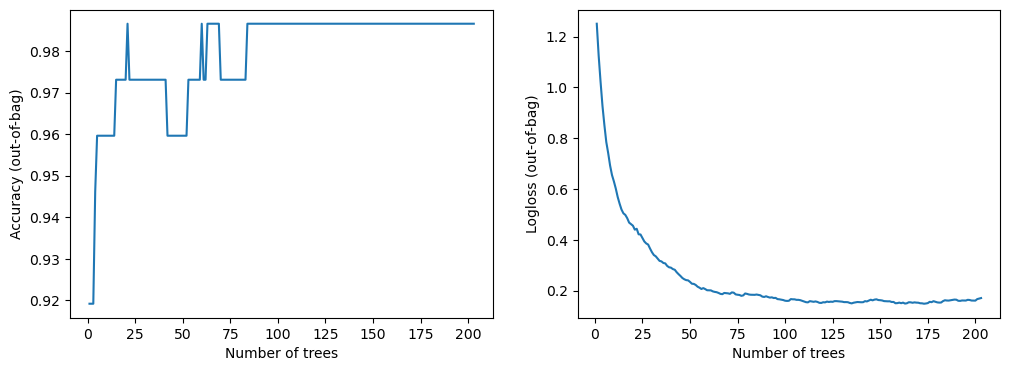


Train: 0.1788 Validation: 0.9113
##### Fold 10
Use /tmp/tmp4gx7zwv8 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:26:31.3460 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:31.3461 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:26:31.3461 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.339236. Found 556 examples.
Training model...
Model trained in 0:00:01.438802
Compiling model...


[INFO 23-07-29 21:26:34.1207 UTC kernel.cc:1242] Loading model from path /tmp/tmp4gx7zwv8/model/ with prefix 33269746b82447e9
[INFO 23-07-29 21:26:34.1330 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:26:34.1330 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1701


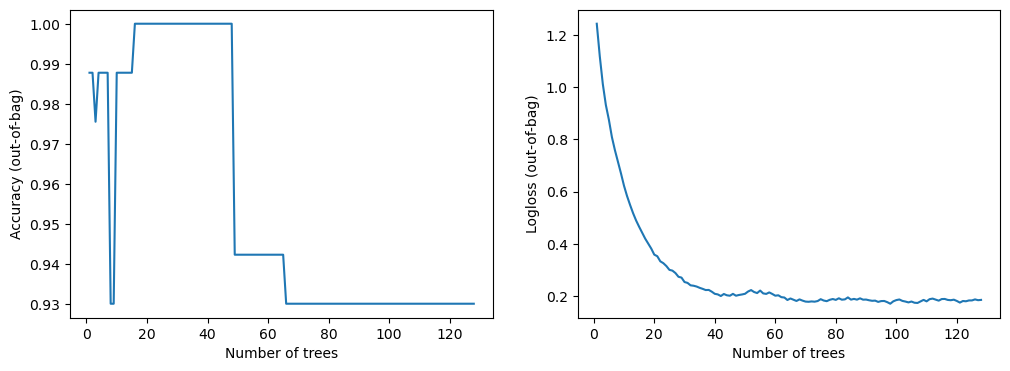


Train: 0.9280 Validation: 0.1701

Train mean: 0.3402 std: 0.2239

Validation mean: 0.3032 std: 0.2237
1/1 [==============================] - 0s 146ms/step


In [14]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_1 = CV_Ensemble_GBT_1.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=5, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_1.save(save_path='/kaggle/working/GBT/1')

# Collect attributes and predictions

train_summary_gbt_1 = CV_Ensemble_GBT_1.X_summary
valid_summary_gbt_1 = CV_Ensemble_GBT_1.valid_summary
test_summary_gbt_1 = CV_Ensemble_GBT_1.predict(X=test_out)
model_gbt_1 = CV_Ensemble_GBT_1.models
metrics_gbt_1 = CV_Ensemble_GBT_1.metrics

##### Fold 1
Use /tmp/tmp1shci0_u as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:13.4887 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:13.4888 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:13.4888 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.272829. Found 555 examples.
Training model...
Model trained in 0:00:01.201390
Compiling model...


[INFO 23-07-29 21:27:15.9600 UTC kernel.cc:1242] Loading model from path /tmp/tmp1shci0_u/model/ with prefix f23487f1dbf147d2
[INFO 23-07-29 21:27:15.9714 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:27:15.9714 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 285ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2472


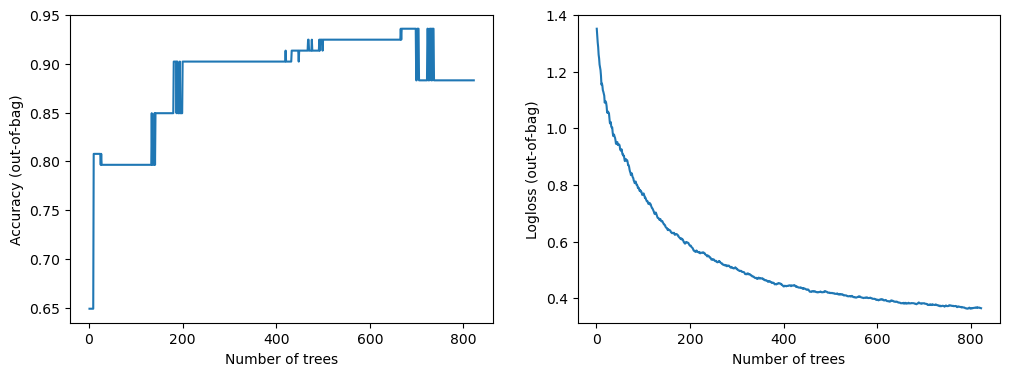


Train: 0.1104 Validation: 0.2472
##### Fold 2
Use /tmp/tmpimyc66z1 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:18.4612 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:18.4612 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:18.4613 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.271940. Found 555 examples.
Training model...
Model trained in 0:00:00.763071
Compiling model...


[INFO 23-07-29 21:27:20.4966 UTC kernel.cc:1242] Loading model from path /tmp/tmpimyc66z1/model/ with prefix fe13257aba334aab
[INFO 23-07-29 21:27:20.5044 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3298


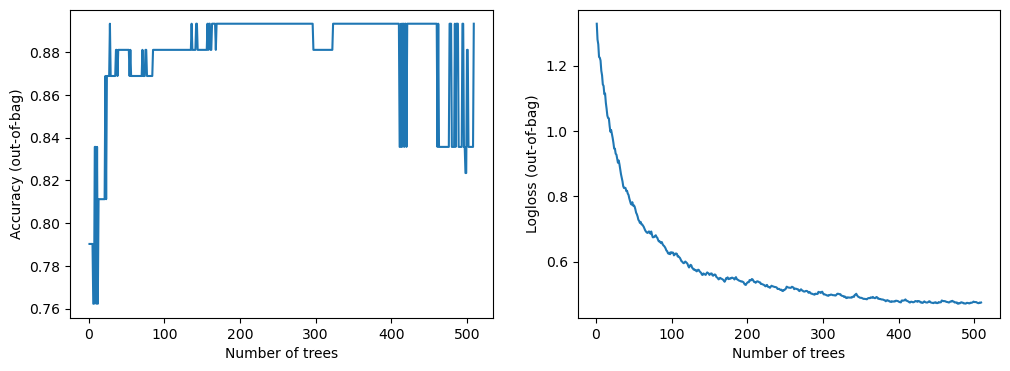


Train: 0.3734 Validation: 0.3298
##### Fold 3
Use /tmp/tmp01d347gk as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:22.9906 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:22.9907 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:22.9907 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.359972. Found 555 examples.
Training model...
Model trained in 0:00:01.560248
Compiling model...


[INFO 23-07-29 21:27:25.9077 UTC kernel.cc:1242] Loading model from path /tmp/tmp01d347gk/model/ with prefix e0aa3c1225d2447d
[INFO 23-07-29 21:27:25.9226 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 283ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1800


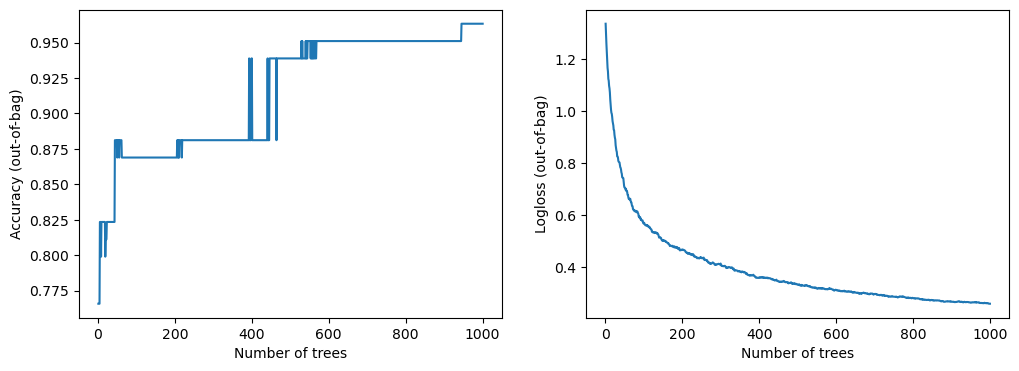


Train: 0.4286 Validation: 0.1800
##### Fold 4
Use /tmp/tmpjirn_hxi as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:28.4090 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:28.4090 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:28.4090 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.271506. Found 555 examples.
Training model...
Model trained in 0:00:00.470736
Compiling model...


[INFO 23-07-29 21:27:30.1557 UTC kernel.cc:1242] Loading model from path /tmp/tmpjirn_hxi/model/ with prefix edfb7dea24e141e1
[INFO 23-07-29 21:27:30.1605 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:27:30.1607 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2218


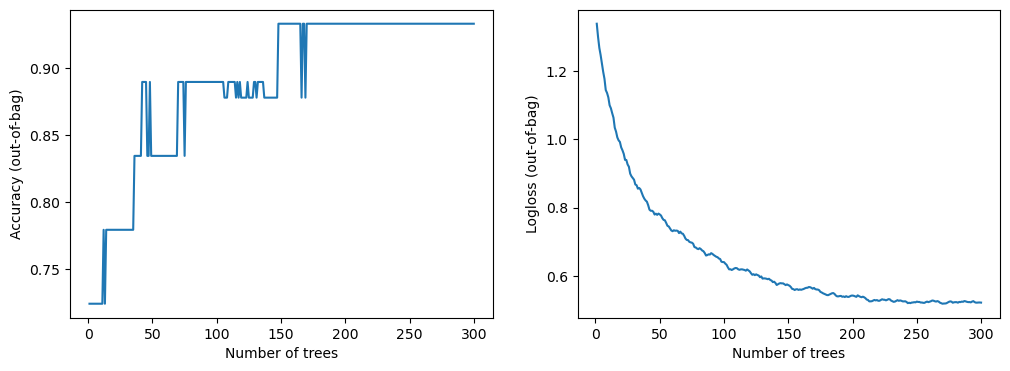


Train: 0.3504 Validation: 0.2218
##### Fold 5
Use /tmp/tmpgcwbbqkg as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:32.6031 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:32.6031 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:32.6032 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.318920. Found 555 examples.
Training model...
Model trained in 0:00:00.625074
Compiling model...


[INFO 23-07-29 21:27:34.5505 UTC kernel.cc:1242] Loading model from path /tmp/tmpgcwbbqkg/model/ with prefix e17eef5f14d64d73
[INFO 23-07-29 21:27:34.5571 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2437


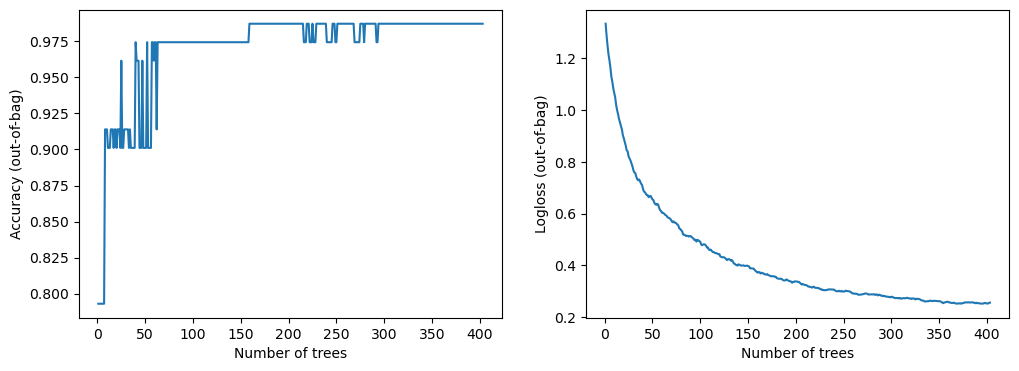


Train: 0.3695 Validation: 0.2437
##### Fold 6
Use /tmp/tmp3seizivr as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:37.0531 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:37.0531 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:37.0531 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.316323. Found 555 examples.
Training model...
Model trained in 0:00:00.735167
Compiling model...


[INFO 23-07-29 21:27:39.1088 UTC kernel.cc:1242] Loading model from path /tmp/tmp3seizivr/model/ with prefix e1f3fdf0b103472a
[INFO 23-07-29 21:27:39.1155 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2334


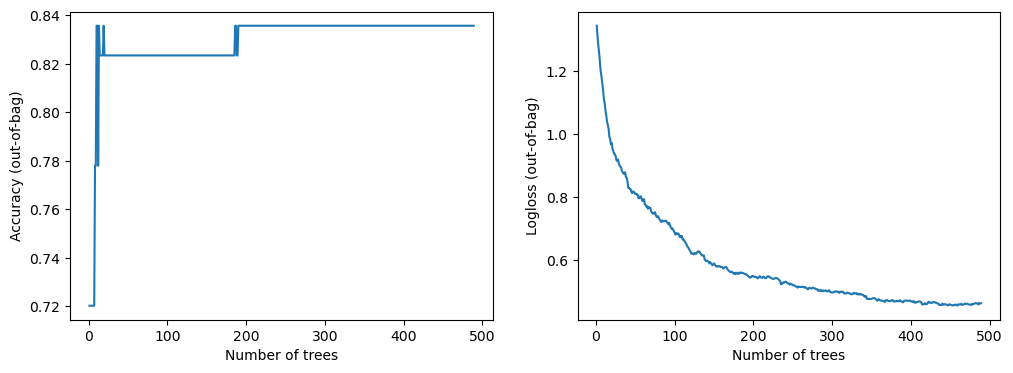


Train: 0.3818 Validation: 0.2334
##### Fold 7
Use /tmp/tmp55iorpgj as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:41.5686 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:41.5687 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:41.5687 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.317133. Found 555 examples.
Training model...
Model trained in 0:00:00.680542
Compiling model...


[INFO 23-07-29 21:27:43.5697 UTC kernel.cc:1242] Loading model from path /tmp/tmp55iorpgj/model/ with prefix 34721d76148f40ed
[INFO 23-07-29 21:27:43.5758 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:27:43.5759 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 281ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1783


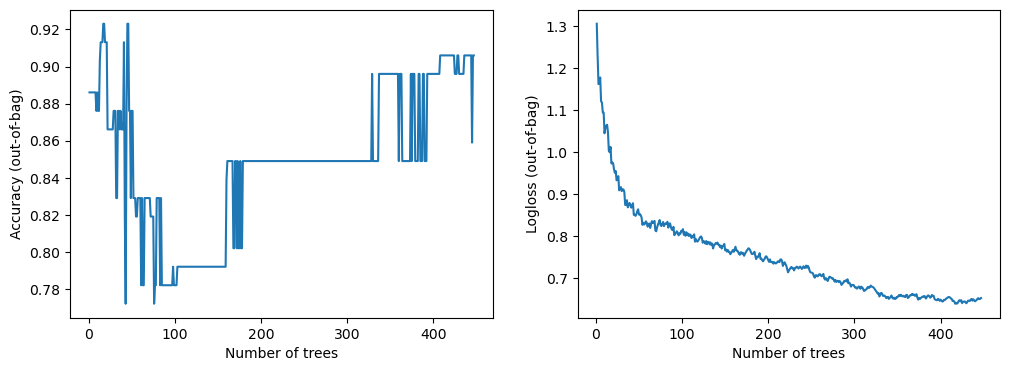


Train: 0.3857 Validation: 0.1783
##### Fold 8
Use /tmp/tmpkajcpwi5 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:46.0503 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:46.0504 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:46.0504 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.294190. Found 556 examples.
Training model...
Model trained in 0:00:00.772614
Compiling model...


[INFO 23-07-29 21:27:48.1182 UTC kernel.cc:1242] Loading model from path /tmp/tmpkajcpwi5/model/ with prefix 7680194399f74b4c
[INFO 23-07-29 21:27:48.1261 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1534


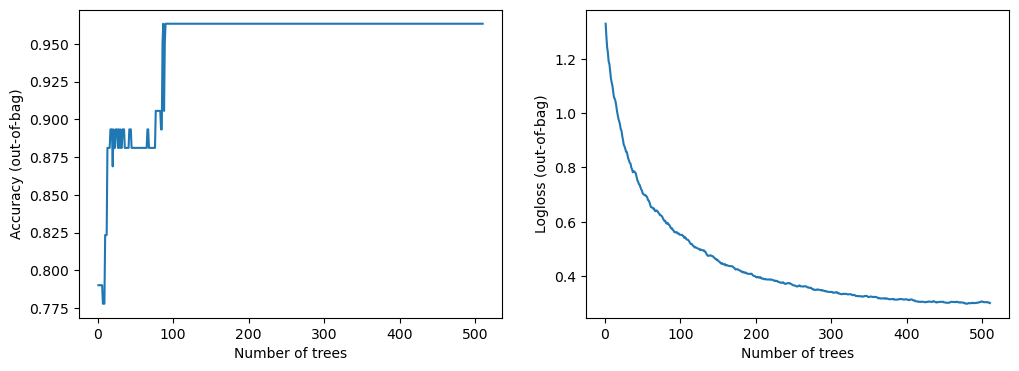


Train: 0.3152 Validation: 0.1534
##### Fold 9
Use /tmp/tmpy992ol2q as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:50.6164 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:50.6165 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:50.6165 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.323376. Found 556 examples.
Training model...
Model trained in 0:00:00.864135
Compiling model...


[INFO 23-07-29 21:27:52.8047 UTC kernel.cc:1242] Loading model from path /tmp/tmpy992ol2q/model/ with prefix 8d6337bdf0864c63
[INFO 23-07-29 21:27:52.8126 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3722


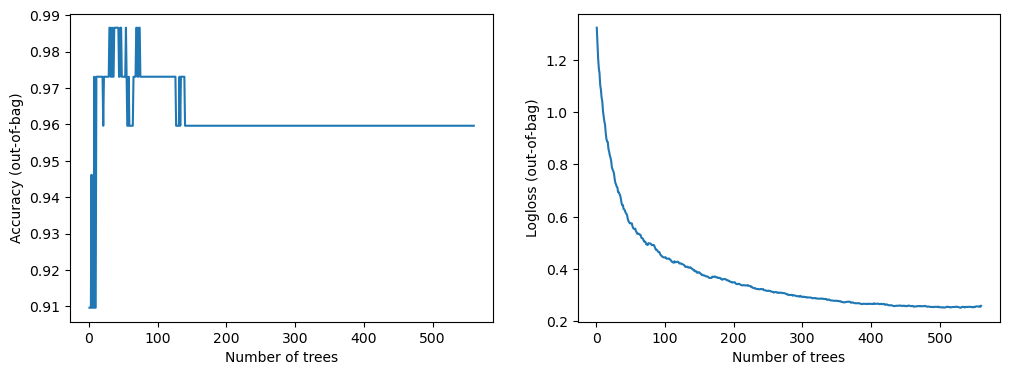


Train: 0.2672 Validation: 0.3722
##### Fold 10
Use /tmp/tmp56k7eshj as temporary training directory
Reading training dataset...


[WARNING 23-07-29 21:27:55.3110 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:55.3111 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 21:27:55.3111 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.378281. Found 556 examples.
Training model...
Model trained in 0:00:00.646689
Compiling model...


[INFO 23-07-29 21:27:57.3385 UTC kernel.cc:1242] Loading model from path /tmp/tmp56k7eshj/model/ with prefix 81a558c19b3248a7
[INFO 23-07-29 21:27:57.3453 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 21:27:57.3455 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9836 - balanced_log_loss: 0.1415


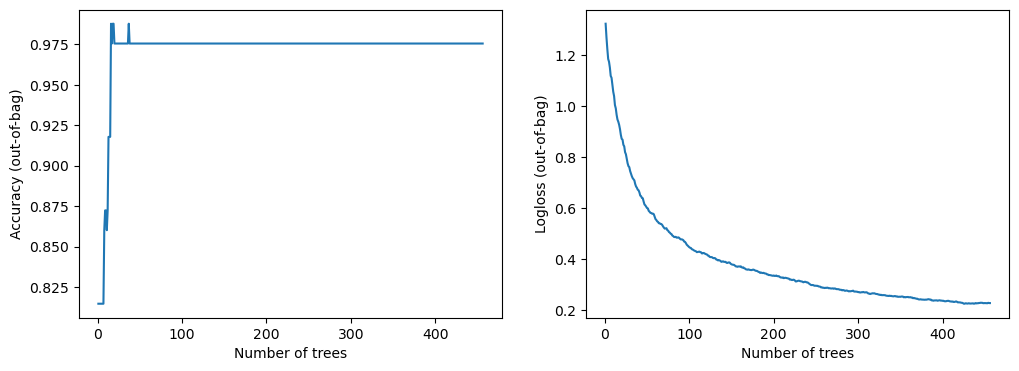


Train: 0.5158 Validation: 0.1415

Train mean: 0.3498 std: 0.1066

Validation mean: 0.2301 std: 0.0742
1/1 [==============================] - 0s 145ms/step


In [15]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_2 = CV_Ensemble_GBT_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=2, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_2.save(save_path='/kaggle/working/GBT/2')

# Collect attributes and predictions

train_summary_gbt_2 = CV_Ensemble_GBT_2.X_summary
valid_summary_gbt_2 = CV_Ensemble_GBT_2.valid_summary
test_summary_gbt_2 = CV_Ensemble_GBT_2.predict(X=test_out)
model_gbt_2 = CV_Ensemble_GBT_2.models
metrics_gbt_2 = CV_Ensemble_GBT_2.metrics

# TabPFN

In [16]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics

class TabPFN_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = TabPFNClassifier, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(N_ensemble_configurations=64)):
        
        # Case CV Ensmble
        # TODO: Case of N_ensemble_configurations
        
        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
            print('##### Fold',i)
            # Fetch values corresponding to the index 
            train_df = X.iloc[train_index]
            valid_df = X.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[self.features+[self.label]]
            valid_df = valid_df[self.features+[self.label]]

            # Define & Train the model
            model = self.model_obj(**model_kwargs)
            model.fit(train_df[self.features],train_df[self.label])

            # Store the model
            self.models[i] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[self.features])[:,1]
            p_val = model.predict_proba(valid_df[self.features])[:,1]

            # Predict Values
            self.X_summary.loc[train_ids, i] = p_train
            self.valid_summary.loc[valid_ids, 0] = p_val

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[self.label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[self.label].values,y_pred=p_val)

            balanced_logloss_train[i] = train_metric
            balanced_logloss_val[i] = val_metric

            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
        print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict_proba(X[self.features])[:,1]
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            joblib.dump(value=model, filename=f'{save_path}/models/{fold}.pickle')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = joblib.load(filename=f'{save_path}/models/{name}')
            
        return self

Before
```python
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)
```

In [17]:
%%time
# TabPFN tabpfn_

features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_1, test_summary_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
    train=train_out,test=test_out, features=features_slice)

os.makedirs('/kaggle/working/TabPFN/1',exist_ok=True)
joblib.dump(value=model_tabpfn_1, filename='/kaggle/working/TabPFN/1/1.pickle')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515
CPU times: user 2min 54s, sys: 53 s, total: 3min 47s
Wall time: 1min 56s


['/kaggle/working/TabPFN/1/1.pickle']

In [18]:
%%time
# TabPFN
features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# train
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs = dict(N_ensemble_configurations=64))

# save
TabPFN_CV_Ensemble_2.save(save_path='/kaggle/working/TabPFN/2')

# Collect attributes and predictions

train_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.X_summary
valid_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.valid_summary
test_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.predict(X=test_out)
model_tabpfn_2 = TabPFN_CV_Ensemble_2.models
metrics_tabpfn_2 = TabPFN_CV_Ensemble_2.metrics

# for inference load

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble_2_load.load(save_path='/kaggle/working/TabPFN/2')


# train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
#     train=train_out,test=test_out, features=features_slice, n_splits=6)

##### Fold 0
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0591 Validation: 0.1325
##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0528 Validation: 0.3273
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0505 Validation: 0.3091
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.2504
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0512 Validation: 0.2377
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0519 Validation: 0.4155

Train mean: 0.0528 std: 0.0032

Validation mean: 0.2788 std: 0.0958
CPU times: user 19min 51s, sys: 5min 41s, total: 25min 32s
Wall time: 12min 58s


# Ensemble CV

Idea to create Entity that can accept multiple previously fitted Regressors and then create final estimate.

In [19]:
class Diff_Class_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, label = "Class"):
        self.label: str = label
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list() # Shall be Union of all features
        self.models: dict = dict() # Each Feature is a scikit-learn compatible & fitted
        self.metrics: dict = dict()
        self.weights: np.ndarray = None
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, 
            models: list, weights: np.ndarray, # List of Estimated Regressors 
            splitter = StratifiedKFold()):
        
        # Count how many sub models we have 
        n_models = len(models)
        self.models = dict()
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan), index=X.index) # For In-Sample Predictions of each Fold
     
        # Make Estimations
        for i,model in enumerate(models):
            X_predicted: pd.DataFrame = model.predict(X) # Shall have original features, which would be checked in DF X
            X_predicted: pd.Series = X_predicted.mean(axis=1)
            self.X_summary[i] = X_predicted
            self.models[i] = model
            self.features = self.features + model.features
        
        # To omit duplications
        self.features: list = list(set(self.features))
        
        # Compute Metrics for each weight combinations
        self.metrics = {}
        for weight in weights:
            #weight = weight.reshape(2,1)
            weight_hash = tuple(weight) #.tolist()
            weight_1D = weight.reshape(-1,1)
            
            self.metrics[weight_hash] = dict(train=list(),valid=list())
            
            for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
                # Fetch values corresponding to the index 
                train_df: np.ndarray = self.X_summary.iloc[train_index].values
                valid_df: np.ndarray = self.X_summary.iloc[valid_index].values

                # Predict value for validation/Submition data
                p_train = train_df.dot(weight_1D)
                p_val = valid_df.dot(weight_1D)

                y_train_true: pd.Series = X.iloc[train_index][self.label].values
                y_valid_true: pd.Series = X.iloc[valid_index][self.label].values

                # Evaluate and store the metrics in respective dicts
                train_metric = balanced_logloss_np(y_true=y_train_true,y_pred=p_train)
                val_metric = balanced_logloss_np(y_true=y_valid_true,y_pred=p_val)

                self.metrics[weight_hash]['train'].append(train_metric)
                self.metrics[weight_hash]['valid'].append(val_metric)
            
            self.metrics[weight_hash]['train_mean'] = np.mean(self.metrics[weight_hash]['train'])
            self.metrics[weight_hash]['train_std'] = np.std(self.metrics[weight_hash]['train'])
            self.metrics[weight_hash]['valid_mean'] = np.mean(self.metrics[weight_hash]['valid'])
            self.metrics[weight_hash]['valid_std'] = np.std(self.metrics[weight_hash]['valid'])
            
        # TODO: Some Logic
        self.weights: np.ndarray = weights[0,:].reshape(-1,1)
            
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_models = len(self.models)
        Y_Preds = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan),
                               index=X.index)

        for i, model in enumerate(self.models.values()):
            Y_Preds[i] = model.predict(X).mean(axis=1)
            
        Y_Preds: np.ndarray = Y_Preds.values
        
        y_pred = Y_Preds.dot(self.weights)
        
        return y_pred

# Initialise

Diff_Class_Ensemble_3Class = Diff_Class_Ensemble(label='Class')

# Fit 
my_splitter = StratifiedKFold(n_splits=3,shuffle=True, random_state=1902)

# Weights
my_weights = list(itertools.permutations(iterable=np.linspace(0., 1., 21), r=3))
my_weights = [i for i in my_weights if round(sum(i),4) == 1]
my_weights = [i for i in my_weights if round(min(i),4) >= .15]

my_weights = np.array(my_weights)


Diff_Class_Ensemble_3Class = Diff_Class_Ensemble_3Class.fit(X=train_out,
                                                            models = [CV_Ensemble_GBT_2, 
                                                                      CV_Ensemble_3,
                                                                     TabPFN_CV_Ensemble_2], 
                                                            splitter = my_splitter,
                                                            weights = my_weights)

1/1 [==============================] - 0s 177ms/step


In [20]:
pd.DataFrame(Diff_Class_Ensemble_3Class.metrics).T

train  \
0.15 0.20 0.65  [0.1055688059031212, 0.10202166121991016, 0.09...   
     0.25 0.60  [0.1115523036552436, 0.10818626019766597, 0.10...   
     0.30 0.55  [0.11763339703591297, 0.11445443652971748, 0.1...   
     0.35 0.50  [0.12381675172010392, 0.12083137960032025, 0.1...   
     0.40 0.45  [0.13010751937158868, 0.12732285026502405, 0.1...   
     0.45 0.40  [0.13651141519494966, 0.13393528501098573, 0.1...   
     0.50 0.35  [0.14303481367149035, 0.14067592831782702, 0.1...   
     0.55 0.30  [0.14968486822579244, 0.14755300372758326, 0.1...   
     0.60 0.25  [0.15646966295382714, 0.1545759392923728, 0.14...   
     0.65 0.20  [0.16339840818958334, 0.16175567147689487, 0.1...   
0.20 0.15 0.65  [0.10185492918136695, 0.09918364074406529, 0.0...   
     0.25 0.55  [0.11381865782245736, 0.11153735951350988, 0.1...   
     0.30 0.50  [0.11994865371781516, 0.11787327028239397, 0.1...   
     0.35 0.45  [0.12618388902923844, 0.12432267273978885, 0.1...   
     0.45 0.35  [0.13899280855962548, 0.13758846694424465, 0.1...   
     0.50 0.30  [0.14557956167680627, 0.1444203530037876, 0.13...   
     0.55 0.25  [0.15229795425874404, 0.15139713708386215, 0.1...   
     0.65 0.15  [0.16616657329110462, 0.165831636264681, 0.153...   
0.25 0.15 0.60  [0.10408561289774704, 0.10248391669741061, 0.0...   
     0.20 0.55  [0.11006611758670143, 0.10867373026072644, 0.1...   
     0.30 0.45  [0.1223272552932331, 0.12137974695858836, 0.11...   
     0.35 0.40  [0.12861808074962766, 0.12790811727653212, 0.1...   
     0.40 0.35  [0.1350235071951725, 0.13456281744810428, 0.12...   
     0.45 0.30  [0.14155024134006577, 0.14135215884632213, 0.1...   
     0.55 0.20  [0.1549990183610394, 0.15537480225493855, 0.14...   
     0.60 0.15  [0.16193965726314205, 0.1626327135370314, 0.15...   
0.30 0.15 0.55  [0.10637406636609559, 0.1058627452193573, 0.10...   
     0.20 0.50  [0.11240411395203112, 0.11212199274341056, 0.1...   
     0.25 0.45  [0.11853563569382797, 0.11849314647490879, 0.1...   
     0.45 0.25  [0.144190638991946, 0.1452405429019996, 0.1350...   
     0.50 0.20  [0.1509218063533475, 0.15228917836602854, 0.14...   
     0.55 0.15  [0.15779763670298141, 0.15950695697971357, 0.1...   
0.35 0.15 0.50  [0.10872416167637804, 0.1093272132005265, 0.10...   
     0.20 0.45  [0.11480723293664147, 0.1156620721919129, 0.10...   
     0.25 0.40  [0.12099526460274629, 0.1221148101648753, 0.11...   
     0.40 0.25  [0.14024981834258723, 0.1422605391994852, 0.13...   
     0.45 0.20  [0.1469225657168569, 0.1492719604518668, 0.138...   
     0.50 0.15  [0.1537375866511724, 0.15645330436375549, 0.14...   
0.40 0.15 0.45  [0.11114042108682529, 0.11288584761055828, 0.1...   
     0.25 0.35  [0.12352973531128743, 0.12584689733581467, 0.1...   
     0.35 0.25  [0.1363812096176964, 0.13934492632971301, 0.12...   
     0.45 0.15  [0.14975693420482364, 0.15347096665003973, 0.1...   
0.45 0.15 0.40  [0.11362820209889829, 0.11654909084784464, 0.1...   
     0.20 0.35  [0.11983023764352335, 0.12305942837536016, 0.1...   
     0.25 0.30  [0.1261460867873857, 0.12970390199611537, 0.12...   
     0.30 0.25  [0.13258286782049955, 0.13649309778259625, 0.1...   
     0.35 0.20  [0.13914878555368787, 0.14343973268915253, 0.1...   
     0.40 0.15  [0.14585343117657024, 0.1505594298866232, 0.13...   
0.50 0.15 0.35  [0.11619396422975024, 0.12033000333040486, 0.1...   
     0.20 0.30  [0.12246370404765383, 0.1269444856578313, 0.11...   
     0.30 0.20  [0.135370326376849, 0.14062379951982867, 0.130...   
     0.35 0.15  [0.14202513410548953, 0.14771846489502738, 0.1...   
0.55 0.15 0.30  [0.1188456692268875, 0.12424534219510591, 0.11...   
     0.20 0.25  [0.1251903541223695, 0.13097937260328146, 0.12...   
     0.25 0.20  [0.13166196912111608, 0.13787444228381784, 0.1...   
     0.30 0.15  [0.13827039108613598, 0.14494814603348638, 0.1...   
0.60 0.15 0.25  [0.12159341168993565, 0.1283172953645237, 0.11...   
     0.25 0.15  [0.13458783525880966, 0.14224888120375973,

I choose wieghts (manually):
0.35	0.15	0.50

In [21]:
Diff_Class_Ensemble_3Class.weights

array([[0.15],
       [0.2 ],
       [0.65]])

In [22]:
Manual_Best_Weights = np.array([[0.35],[0.15],[0.50]]) # Manual_Best_Weights
Manual_Best_Weights

array([[0.35],
       [0.15],
       [0.5 ]])

In [23]:
Diff_Class_Ensemble_3Class.weights = Manual_Best_Weights

# Cut-Offs

In [24]:
ensemble_final_train_out = Diff_Class_Ensemble_3Class.predict(X=train_out)
# ensemble_final_train_out

1/1 [==============================] - 0s 184ms/step


In [25]:
ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)
# ensemble_final_test_out

1/1 [==============================] - 0s 145ms/step


In [26]:
train_out['Y_Pred'] = ensemble_final_train_out

In [27]:
def compute_cut_off(y_pred: pd.Series, y_true: pd.Series) -> pd.DataFrame:
    # Let's try to find Cutoffs organically
    y_pred.name = 'Pred'
    y_true.name = 'Class'

    tmp = pd.concat([y_pred, y_true], axis=1).sort_index(ascending=True)

    tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
    tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
    tmp['count_cumsum'] = tmp['count'].cumsum()
    tmp['sum_cumsum'] = tmp['sum'].cumsum()

    tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

    tmp['perc_sum'] = [*range(1,101)]

    return tmp

cut_off_df = compute_cut_off(y_pred=train_out['Y_Pred'], y_true=train_out['Class'])

cut_off_df

,count,sum,count_cumsum,sum_cumsum,bads_rate,perc_sum
Pred_Bins,,,,,,
"(-0.000779, 0.00181]",7,0,7,0,0.000000,1
"(0.00181, 0.00245]",6,0,13,0,0.000000,2
"(0.00245, 0.00288]",6,0,19,0,0.000000,3
"(0.00288, 0.00308]",6,0,25,0,0.000000,4
"(0.00308, 0.00368]",6,0,31,0,0.000000,5
"(0.00368, 0.00402]",6,0,37,0,0.000000,6
"(0.00402, 0.00461]",7,0,44,0,0.000000,7
"(0.00461, 0.00563]",6,0,50,0,0.000000,8
"(0.00563, 0.00613]",6,0,56,0,0.000000,9


Manually I choose:
* Lower 0.205 -> to 0
* Upper 0.711 -> to 1

In [28]:
# Lower
train_out['Y_Pred_After_CutOff'] = np.where(train_out['Y_Pred'] <= 0.205,0,train_out['Y_Pred'])

# Upper
train_out['Y_Pred_After_CutOff'] = np.where(train_out['Y_Pred'] >= 0.711,1,train_out['Y_Pred'])

In [29]:
print('Before')
print(balanced_logloss_np(y_pred=train_out['Y_Pred'].values,y_true=train_out['Class'].values))
print('After')
print(balanced_logloss_np(y_pred=train_out['Y_Pred_After_CutOff'].values,y_true=train_out['Class'].values))

Before
0.10725019055236813
After
0.06370863901433406


In [30]:
test_out['Y_Pred'] = ensemble_final_test_out # ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)

# Lower
test_out['Y_Pred_After_CutOff'] = np.where(test_out['Y_Pred'] <= 0.205,0,test_out['Y_Pred'])

# Upper
test_out['Y_Pred_After_CutOff'] = np.where(test_out['Y_Pred'] >= 0.711,1,test_out['Y_Pred'])

In [31]:
test_out

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS_na,CC_na,FL_na,GL_na,CB_na,EL_na,BQ_na,EJ_A,Y_Pred,Y_Pred_After_CutOff
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593116,0.593116
010ebe33f668,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593116,0.593116
02fa521e1838,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593116,0.593116
040e15f562a2,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593116,0.593116
046e85c7cc7f,-1.018705,-1.522401,-0.927922,-0.558863,-0.962863,-2.173291,-0.144715,-2.428708,-0.123575,-1.770874,...,0,0,0,0,0,0,0,1,0.593116,0.593116


# Submission

In [32]:
# submition_total
submition_total = test_out[['Y_Pred_After_CutOff']].copy()
submition_total['class_1'] = submition_total['Y_Pred_After_CutOff']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']].copy()
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [33]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float64
 1   class_1  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0+ bytes
